# Post processing reference data collected using CEO

Collect Earth Online is being used as a tool for collecting cropland reference data, some of the points are labelled as 'mixed' or 'unsure', and others are GFSAD validation points so we need to seperate these from the dataset. We also need to seperate a validation dataset for use in the final map accuracy assessment.

Inputs will be:

1. `ceo-data....csv` : The results from collecting training data in the CEO tool

Output will be:
1. Validation crop/non-crop samples as a shapefile
2. Training crop/non-crop samples as a shapefile
3. 'Mixed' samples as a shapefile (for use in manually copllecting more training data)
4. Crop/non-crop samples to send to RE for use in validating our data collection

***

*Filename guide:*

* `<aez>_training_data.geojson`: The final training dataset that includes CEO data, manually collected polygons, and any pre-existing datasets.
* `validation_samples.shp`: Validation data, collected using CEO, isolated from training data and only to be used for final map validation
* `mixed_samples_points(polys).shp`: The samples labelled as 'mixed' during the CEO process, these are used for guiding manual polygon drawing to increase the amount of training data e.g. using ArcGIS
* `ceo_td_polys.geojson` : training data polygons retrievd from CEO tool, these are combined the manually collected polygons and any pre-existing datasets to produce the `<aez>_training_data.geojson` file


In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import geopandas as gpd
import matplotlib.pyplot as plt

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Analysis Parameters

In [2]:
folder = 'data/training_validation/collect_earth/sahel/'
csv = folder+'ceo-Cropland-Reference-Data-Acquistion---Sahel-Region---Ado-sample-data-2021-03-05.csv'
# csv_1 = folder+'ceo-Cropland-Reference-Data-Acquisition---Northern-Region---Malack-sample-data-2021-02-22.csv'

### Load the dataset

In [3]:
#ground truth shapefile
df = pd.read_csv(csv)
# df1 = pd.read_csv(csv_1)

In [4]:
df.columns

Index(['plot_id', 'sample_id', 'lon', 'lat', 'flagged', 'analyses', 'email',
       'collection_time', 'analysis_duration', 'imagery_title',
       'imagery_attributions', 'sample_geom', 'pl_class', 'pl_gfsad_samp',
       'pl_plotid', 'pl_sampleid', 'smpl_class', 'smpl_gfsad_samp',
       'smpl_plotid', 'smpl_sampleid',
       'Is the sample area entirely: crop, non-crop, mixed, or unsure?'],
      dtype='object')

### Clean up dataframe


In [5]:
#This line if entire dataset:
df = df[['lon', 'lat', 'smpl_sampleid', 'smpl_gfsad_samp','smpl_class','Is the sample area entirely: crop, non-crop, mixed, or unsure?']]
# df1 = df1[['lon', 'lat', 'smpl_sampleid', 'smpl_gfsad_samp','smpl_class','Is the sample area entirely: crop, non-crop, mixed, or unsure?']]

#rename columns
df = df.rename(columns={'Is the sample area entirely: crop, non-crop, mixed, or unsure?':'Class'})
# df1 = df1.rename(columns={'Is the sample area entirely: crop, non-crop, mixed, or unsure?':'Class'})

#remove nan rows
# df = df.dropna()
print(len(df))
# print(len(df1))
df.head()

2100


,lon,lat,smpl_sampleid,smpl_gfsad_samp,smpl_class,Class
0,8.979290,14.905745,0,0,1,non-crop
1,34.078938,13.104983,1,0,2,crop
2,-8.833417,14.507222,2,1,2,crop
3,-8.635415,12.961073,3,0,2,crop
4,-16.017950,15.632303,4,0,2,crop


In [ ]:
df1.head()

In [ ]:
df = pd.concat([df,df1]).drop(columns=['smpl_class'])
print(len(df))
df.head()

### Remove GFSAD validation points


In [6]:
df = df[df['smpl_gfsad_samp']==False]
print(len(df))

2000


***

### Seperate 'Mixed' & 'Unsure' samples

In [7]:
#seperate class
mixed = df[df['Class']=='mixed']
unsure = df[df['Class']=='unsure']
crop = df[df['Class']=='crop']
noncrop = df[df['Class']=='non-crop']

print('Number of samples labelled as mixed: '+str(len(mixed)))
print('Number of samples labelled as unsure: ' + str(len(unsure)))
print('Number of samples labelled as crop: ' + str(len(crop)))
print('Number of samples labelled as non-crop: ' + str(len(noncrop)))


Number of samples labelled as mixed: 287
Number of samples labelled as unsure: 48
Number of samples labelled as crop: 691
Number of samples labelled as non-crop: 974


In [8]:
# export mixed samples as shapefile
mixed = gpd.GeoDataFrame(
    mixed, geometry=gpd.points_from_xy(mixed.lon, mixed.lat, crs='EPSG:4326'))

radius = 20

#convert to equal area to set polygon size in metres
mixed_poly = mixed.to_crs('EPSG:6933')

#create circle buffer around points, then find envelope
mixed_poly['geometry'] = mixed_poly['geometry'].buffer(radius).envelope

#Convert back to lat/lon
mixed_poly = mixed_poly.to_crs('EPSG:4326')

#shuffle so labels aren't sequential
mixed_poly = mixed_poly.reset_index(drop=True).drop(columns=['lon', 'lat']) #'smpl_gfsad_samp'

#add plotid for CEO
mixed_poly['PLOTID'] = range(1,len(mixed_poly)+1)
mixed_poly['SAMPLEID'] = range(1,len(mixed_poly)+1)

mixed_poly.to_file(folder + 'mixed_samples_poly.shp')
mixed.to_file(folder + 'mixed_samples_points.shp')

## Sample to send to Radiant Earth

Randomly select crop and non-crop samples to send to Radiant Earth.

In [9]:
name='Sahel_region_RE_sample.geojson'

In [10]:
#sample 50 points from each class
re_crop = crop.sample(n=50, replace=False).reset_index(drop=True)
re_noncrop = noncrop.sample(n=50, replace=False).reset_index(drop=True)

#merge dfs
re_sample = pd.concat([re_crop,re_noncrop]).reset_index(drop=True)#.drop(columns=['smpl_gfsad_samp'])

re_sample = gpd.GeoDataFrame(
    re_sample, geometry=gpd.points_from_xy(re_sample.lon, re_sample.lat, crs='EPSG:4326')).drop(columns=['lon', 'lat'])

#set radius (in metres) around points
radius = 20

#convert to equal area to set polygon size in metres
re_sample_poly = re_sample.to_crs('EPSG:6933')

#create circle buffer around points, then find envelope
re_sample_poly['geometry'] = re_sample_poly['geometry'].buffer(radius).envelope

#Convert back to lat/lon
re_sample_poly = re_sample_poly.to_crs('EPSG:4326')

#shuffle so labels aren't sequential
re_sample_poly = re_sample_poly.sample(frac=1).reset_index(drop=True)

#export to geojson
re_sample_poly.to_file(folder+name, driver='GeoJSON')

## Isolate samples as a validation dataset

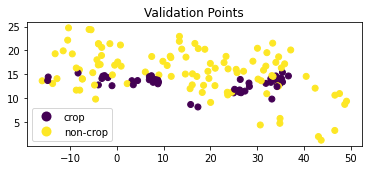

In [11]:
#create ramdom samples
validation_crop = crop.sample(n=50)
validation_noncrop = noncrop.sample(n=100)

#remove samples from crop/non-crop datasets
crop = crop.drop(validation_crop.index)
noncrop = noncrop.drop(validation_noncrop.index)

#join as a single dataset
validation_df = pd.concat([validation_crop, validation_noncrop]).sample(frac=1).reset_index(drop=True)

#create shapefile
validation_df = gpd.GeoDataFrame(
    validation_df, geometry=gpd.points_from_xy(validation_df.lon, validation_df.lat, crs='EPSG:4326'))

#export to file
validation_df.to_file(folder + 'validation_samples.shp')

#plot
validation_df.plot(column='Class', figsize=(6,6), cmap='viridis', legend=True)
plt.title('Validation Points');

## Process remaining points as training data

If collecting more data manually using the 'mixed' samples, then join that shapefile with this dataset after running the code below

In [12]:
td = pd.concat([crop,noncrop]).reset_index(drop=True).drop(columns=['smpl_gfsad_samp'])

td = gpd.GeoDataFrame(
    td, geometry=gpd.points_from_xy(td.lon, td.lat, crs='EPSG:4326')).drop(columns=['lon', 'lat'])

#set radius (in metres) around points
radius = 20

#convert to equal area to set polygon size in metres
td_poly = td.to_crs('EPSG:6933')

#create circle buffer around points, then find envelope
td_poly['geometry'] = td_poly['geometry'].buffer(radius).envelope

#Convert back to lat/lon
td_poly = td_poly.to_crs('EPSG:4326')

#shuffle so labels aren't sequential
td_poly = td_poly.sample(frac=1).reset_index(drop=True).drop(columns=['smpl_sampleid'])


In [13]:
td_poly['Class'] = np.where(td_poly['Class']=='non-crop', 0, td_poly['Class'])
td_poly['Class'] = np.where(td_poly['Class']=='crop', 1, td_poly['Class'])

In [14]:
td_poly.to_file(folder + 'ceo_td_polys.geojson', driver='GeoJSON')

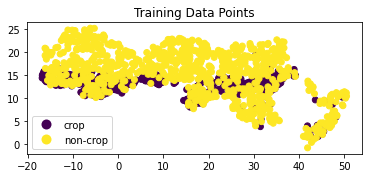

In [15]:
td.plot(column='Class', figsize=(6,6), cmap='viridis', legend=True)
plt.title('Training Data Points');

## Optional: Join training data with other data

e.g. manually collected data and/or pre-existing datasets

In [ ]:
folder = 'data/training_validation/collect_earth/eastern/'

In [ ]:
#add manually collected polygons
manual = gpd.read_file(folder+'eastern_manual_crop_polys.shp')#.drop(['SMPL_SAMPL'],axis=1)
manual['Class'] = np.where(manual['Class']=='crop', 1, manual['Class'])
manual['Class'] = np.where(manual['Class']=='non-crop', 0, manual['Class'])

In [ ]:
#sample the radiant earth dataset
re = gpd.read_file(folder+'ref_eastafrican_crops.geojson')

num_of_samples=len(re)

re = re.sample(n=num_of_samples).drop(['Estimated Harvest Date', 'id'], axis=1)
re['Class'] = 1

In [ ]:
#open Collect Earth td polys
td_poly=gpd.read_file(folder + 'ceo_td_polys.geojson')
# td_poly=gpd.read_file(folder + 'Eastern_ceo_training_samples.geojson')

In [ ]:
training_data = pd.concat([manual,re,td_poly]).reset_index(drop=True)

In [ ]:
training_data['Class'] = training_data['Class'].astype(int)

In [ ]:
print('No. of samples: '+str(len(training_data)))
print('Crop samples = '+str(len(training_data[training_data['Class']==1])))
print('Non-Crop samples = '+str(len(training_data[training_data['Class']==0])))

In [ ]:
training_data.to_file(folder+'Eastern_training_data_20210301.geojson', driver='GeoJSON')

## Use this to find difference between analyst's lables and the original GFSAD stratification label

In [ ]:
# df['Class'] = np.where(df['Class']=='non-crop', 0, df['Class'])
# df['Class'] = np.where(df['Class']=='crop', 1, df['Class'])

# df['smpl_class'] = np.where(df['smpl_class']==1, 0, df['smpl_class'])
# df['smpl_class'] = np.where(df['smpl_class']==2, 1, df['smpl_class'])

# df = df.drop(df[df['Class']=='mixed'].index)
# df = df.drop(df[df['Class']=='unsure'].index)

# df=df[df['smpl_class']!= df['Class']]

# df=df.rename(columns={'smpl_class':'gfsad_class', 'Class': 'ken_class', 'smpl_sampleid':'original_sampleid'}).drop(columns=['smpl_gfsad_samp'])

# crop=df[df['gfsad_class']==1].sample(n=100, replace=False).reset_index(drop=True)
# noncrop = df[df['gfsad_class']==0].reset_index(drop=True) #grab all points

# #merge dfs
# df = pd.concat([crop,noncrop]).reset_index(drop=True)

# gdf = gpd.GeoDataFrame(
#     df, geometry=gpd.points_from_xy(df.lon, df.lat, crs='EPSG:4326'))

# radius = 20

# #convert to equal area to set polygon size in metres
# gdf_poly = gdf.to_crs('EPSG:6933')

# #create circle buffer around points, then find envelope
# gdf_poly['geometry'] = gdf_poly['geometry'].buffer(radius).envelope

# #Convert back to lat/lon
# gdf_poly = gdf_poly.to_crs('EPSG:4326')

# #shuffle so labels aren't sequential
# gdf_poly = gdf_poly.reset_index(drop=True).drop(columns=['lon', 'lat'])

# #add plotid for CEO
# gdf_poly['PLOTID'] = range(1,len(gdf_poly)+1)
# gdf_poly['SAMPLEID'] = range(1,len(gdf_poly)+1)

# gdf_poly.to_file(folder + 'gfsad_divergence_samples_poly.shp')